# Clasificadores en inglés

In [142]:
import seaborn as sns, numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib.pyplot as plt

In [143]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May 27 23:09:38 2021

@author: marti
"""
#%% Libraries and data
import pandas as pd
from textblob import TextBlob

df = pd.read_csv('../data/EN/vacunes_100rt_en.csv', index_col=0)
df = df[df.columns[1:]]

#%% Sentiment
def get_polarity(text):
    return TextBlob(text).sentiment

sentiment = df['content'].apply(get_polarity)

df['polarity'] = sentiment.apply(lambda x: x[0])
df['subjectivity'] = sentiment.apply(lambda x: x[1])


In [144]:
all_df = pd.read_csv('../preprocessing/tweets_preprocessed.csv', index_col=0)

df = pd.read_csv('../data/samples/evaluation1_labeled.csv', index_col=1)
df.labels = df.labels.map({0:0, 1:2, 2:1, 3:1})
df.rename(columns={'labels': 'label'}, inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

df2 = pd.read_csv('../data/samples/vacunes_100rt_evaluation2_label.csv', index_col=0)
df2.label = df2.label.map({'neg': 0, 'neu': 1, 'irr': 1, 'pos': 2})

df = df.append(df2)

df.drop_duplicates(subset='content', keep='first', inplace=True)

all_df.loc[df.index, 'label'] = df.label

df_blob = pd.read_csv('../data/EN/vacunes_100rt_en_textblob.csv', index_col=0)
all_df['polarity'] = df_blob.polarity
all_df['subjectivity'] = df_blob.subjectivity

df['polarity'] = all_df.loc[df.index, 'polarity']
df['subjectivity'] = all_df.loc[df.index, 'subjectivity']


import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df_blob['scores'] = df_blob['content'].apply( lambda x: sid.polarity_scores(x)['compound'] )
all_df['polarity_vader'] = df_blob['scores']

df['polarity_vader'] = all_df.loc[df.index, 'polarity_vader']

from sentiment_analysis_spanish import sentiment_analysis
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
all_df['polarity_spanish'] = all_df.content.apply(lambda x: sentiment.sentiment(x))
df['polarity_spanish'] = all_df.loc[df.index, 'polarity_spanish']

df = df[df.label.notna()]
orig_df = df.copy()

/home/marti/.pyenv/versions/capstone/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/marti/.pyenv/versions/capstone/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

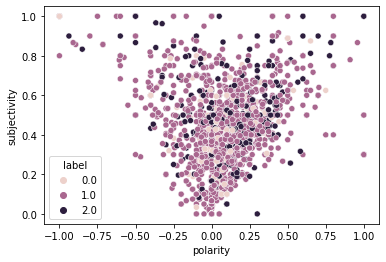

In [145]:
features = ['polarity', 'subjectivity']

df = orig_df[features + ['label'] ]
df_train, df_test, y_train, y_test = train_test_split(df, df['label'], test_size=.2, random_state=4562)

sns.scatterplot(data=df, x="polarity", y="subjectivity", hue="label")

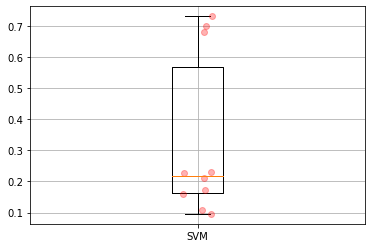

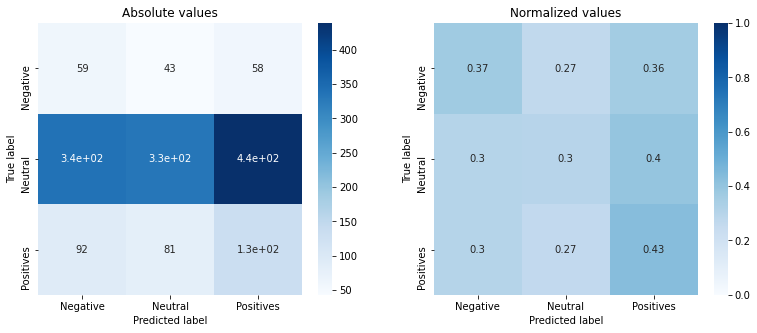

In [146]:
#Create a 10-fold cross validation set
acc = np.zeros((10,1))
conf_matrix = np.zeros((3,3))

kf=KFold(n_splits=10, shuffle=False) #random_state=0 has been removed
kf.get_n_splits()

i=0
for train_index, test_index in kf.split(df_train):
    #print(train_index)
    
    X_train, X_val = df_train.iloc[train_index][features], df_train.iloc[test_index][features]
    
   
    scaler = MinMaxScaler().fit(X_train)
    X_train, X_val = scaler.transform(X_train), scaler.transform(X_val)
    
    y_train, y_val = df_train.iloc[train_index].label, df_train.iloc[test_index].label
    
    svc = svm.SVC(C=.01, kernel='linear', class_weight="balanced", gamma='scale')
    #svc = naive_bayes.MultinomialNB()
    #svc = neighbors.KNeighborsClassifier(n_neighbors=1)
    #svc = tree.DecisionTreeClassifier()

    svc.fit(X_train,y_train)
    
    yhat_svc=svc.predict(X_val)
    
    acc[i][0] = metrics.accuracy_score(yhat_svc, y_val)
    
    conf_matrix += metrics.confusion_matrix(y_val, yhat_svc)
    
    i=i+1
    
plt.boxplot(acc);
for i in range(1):
    xderiv = (i+1)*np.ones(acc[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['SVM'])   
ax.grid()

conf_matrix_normalized = np.apply_along_axis(lambda x: x/ x.sum(), 1, conf_matrix)
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.heatmap(conf_matrix, annot=True, ax=ax[0], cmap=sns.color_palette("Blues", as_cmap=True))
sns.heatmap(conf_matrix_normalized, vmin=0, vmax=1, center=.5, annot=True, ax=ax[1], cmap=sns.color_palette("Blues", as_cmap=True))

ax[0].set_title('Absolute values')
ax[1].set_title('Normalized values')
for ax_ in ax:
    ax_.set_xticklabels(['Negative', 'Neutral', 'Positives'])
    ax_.set_yticklabels(['Negative', 'Neutral', 'Positives'])
    ax_.set_xlabel('Predicted label')
    ax_.set_ylabel('True label')

In [147]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
           ('vect', MinMaxScaler()),
           ('clf', svm.SVC(class_weight='balanced')) ])

parameters = {'clf__kernel': ['linear', 'rbf'],
             'clf__C': [.01, .1, 1, 5, 10, 20, 50, 100],
              'clf__gamma': ['scale', 'auto']}

grid_search = GridSearchCV(pipeline, parameters, scoring='f1_weighted', n_jobs=-1, verbose=4)


grid_search.fit(df_train[features], df_train.label)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', MinMaxScaler()),
                                       ('clf', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 5, 10, 20, 50, 100],
                         'clf__gamma': ['scale', 'auto'],
                         'clf__kernel': ['linear', 'rbf']},
             scoring='f1_weighted', verbose=4)

In [148]:
resultados = pd.DataFrame(grid_search.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(100)

,param_clf__C,param_clf__gamma,param_clf__kernel,mean_test_score,std_test_score
0,0.01,scale,linear,0.581968,0.000604
2,0.01,auto,linear,0.581968,0.000604
3,0.01,auto,rbf,0.581968,0.000604
1,0.01,scale,rbf,0.581968,0.000604
8,1,scale,linear,0.527379,0.011031
10,1,auto,linear,0.527379,0.011031
12,5,scale,linear,0.527134,0.014898
14,5,auto,linear,0.527134,0.014898
22,20,auto,linear,0.526591,0.014195
20,20,scale,linear,0.526591,0.014195


<AxesSubplot:xlabel='polarity', ylabel='polarity_vader'>

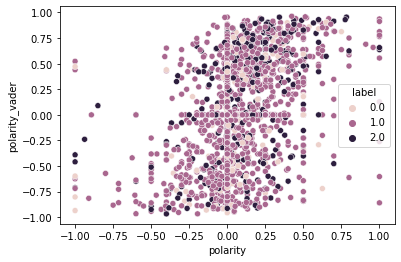

In [149]:
features = ['polarity', 'subjectivity', 'polarity_vader']

df = orig_df[features + ['label'] ]
df_train, df_test, y_train, y_test = train_test_split(df, df['label'], test_size=.2, random_state=4562)

sns.scatterplot(data=df, x="polarity", y="polarity_vader", hue="label")

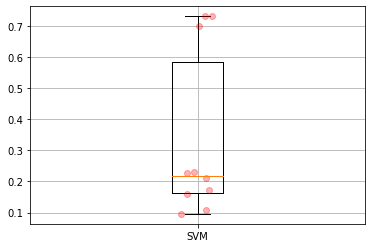

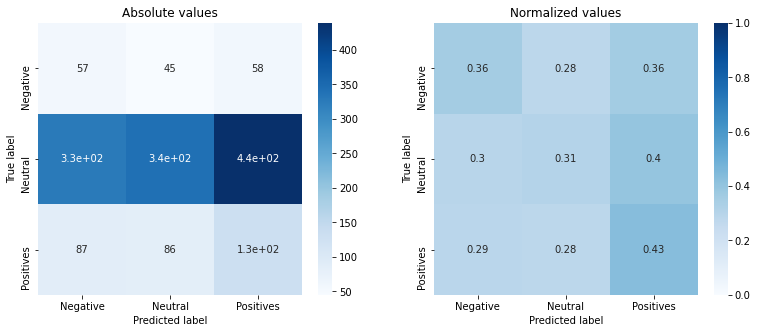

In [150]:
#Create a 10-fold cross validation set
acc = np.zeros((10,1))
conf_matrix = np.zeros((3,3))

kf=KFold(n_splits=10, shuffle=False) #random_state=0 has been removed
kf.get_n_splits()

i=0
for train_index, test_index in kf.split(df_train):
    #print(train_index)
    
    X_train, X_val = df_train.iloc[train_index][features], df_train.iloc[test_index][features]
    
   
    scaler = MinMaxScaler().fit(X_train)
    X_train, X_val = scaler.transform(X_train), scaler.transform(X_val)
    
    y_train, y_val = df_train.iloc[train_index].label, df_train.iloc[test_index].label
    
    svc = svm.SVC(C=.01, kernel='linear', class_weight="balanced", gamma='scale')
    #svc = naive_bayes.MultinomialNB()
    #svc = neighbors.KNeighborsClassifier(n_neighbors=1)
    #svc = tree.DecisionTreeClassifier()

    svc.fit(X_train,y_train)
    
    yhat_svc=svc.predict(X_val)
    
    acc[i][0] = metrics.accuracy_score(yhat_svc, y_val)
    
    conf_matrix += metrics.confusion_matrix(y_val, yhat_svc)
    
    i=i+1
    
plt.boxplot(acc);
for i in range(1):
    xderiv = (i+1)*np.ones(acc[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['SVM'])   
ax.grid()

conf_matrix_normalized = np.apply_along_axis(lambda x: x/ x.sum(), 1, conf_matrix)
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.heatmap(conf_matrix, annot=True, ax=ax[0], cmap=sns.color_palette("Blues", as_cmap=True))
sns.heatmap(conf_matrix_normalized, vmin=0, vmax=1, center=.5, annot=True, ax=ax[1], cmap=sns.color_palette("Blues", as_cmap=True))

ax[0].set_title('Absolute values')
ax[1].set_title('Normalized values')
for ax_ in ax:
    ax_.set_xticklabels(['Negative', 'Neutral', 'Positives'])
    ax_.set_yticklabels(['Negative', 'Neutral', 'Positives'])
    ax_.set_xlabel('Predicted label')
    ax_.set_ylabel('True label')

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
           ('vect', MinMaxScaler()),
           ('clf', svm.SVC(class_weight='balanced')) ])

parameters = {'clf__kernel': ['linear', 'rbf'],
             'clf__C': [.01, .1, 1, 5, 10, 20, 50, 100],
              'clf__gamma': ['scale', 'auto']}

grid_search = GridSearchCV(pipeline, parameters, scoring='f1_weighted', n_jobs=-1, verbose=4)


grid_search.fit(df_train[features], df_train.label)
resultados = pd.DataFrame(grid_search.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(100)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,param_clf__C,param_clf__gamma,param_clf__kernel,mean_test_score,std_test_score
0,0.01,scale,linear,0.581968,0.000604
1,0.01,scale,rbf,0.581968,0.000604
2,0.01,auto,linear,0.581968,0.000604
3,0.01,auto,rbf,0.581968,0.000604
4,0.1,scale,linear,0.463385,0.025644
6,0.1,auto,linear,0.463385,0.025644
21,20,scale,rbf,0.451467,0.016042
17,10,scale,rbf,0.450236,0.017659
29,100,scale,rbf,0.448736,0.022157
25,50,scale,rbf,0.438372,0.017656


<AxesSubplot:xlabel='polarity', ylabel='polarity_vader'>

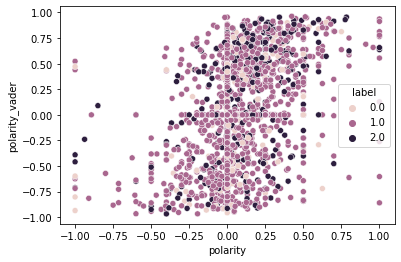

In [152]:
features = ['polarity', 'subjectivity', 'polarity_vader', 'polarity_spanish']

df = orig_df[features + ['label'] ]
df_train, df_test, y_train, y_test = train_test_split(df, df['label'], test_size=.2, random_state=4562)

sns.scatterplot(data=df, x="polarity", y="polarity_vader", hue="label")

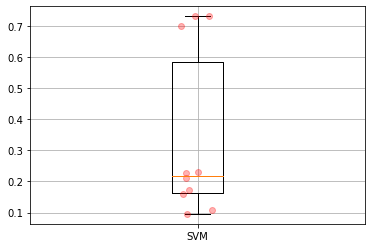

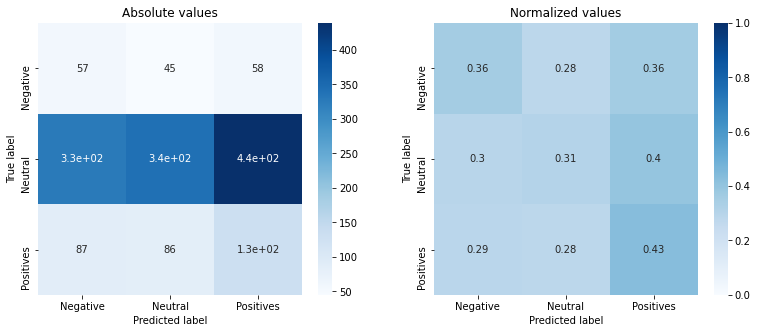

In [153]:
#Create a 10-fold cross validation set
acc = np.zeros((10,1))
conf_matrix = np.zeros((3,3))

kf=KFold(n_splits=10, shuffle=False) #random_state=0 has been removed
kf.get_n_splits()

i=0
for train_index, test_index in kf.split(df_train):
    #print(train_index)
    
    X_train, X_val = df_train.iloc[train_index][features], df_train.iloc[test_index][features]
    
   
    scaler = MinMaxScaler().fit(X_train)
    X_train, X_val = scaler.transform(X_train), scaler.transform(X_val)
    
    y_train, y_val = df_train.iloc[train_index].label, df_train.iloc[test_index].label
    
    svc = svm.SVC(C=.01, kernel='linear', class_weight="balanced", gamma='scale')
    #svc = naive_bayes.MultinomialNB()
    #svc = neighbors.KNeighborsClassifier(n_neighbors=1)
    #svc = tree.DecisionTreeClassifier()

    svc.fit(X_train,y_train)
    
    yhat_svc=svc.predict(X_val)
    
    acc[i][0] = metrics.accuracy_score(yhat_svc, y_val)
    
    conf_matrix += metrics.confusion_matrix(y_val, yhat_svc)
    
    i=i+1
    
plt.boxplot(acc);
for i in range(1):
    xderiv = (i+1)*np.ones(acc[:,i].shape)+(np.random.rand(10,)-0.5)*0.1
    plt.plot(xderiv,acc[:,i],'ro',alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['SVM'])   
ax.grid()

conf_matrix_normalized = np.apply_along_axis(lambda x: x/ x.sum(), 1, conf_matrix)
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.heatmap(conf_matrix, annot=True, ax=ax[0], cmap=sns.color_palette("Blues", as_cmap=True))
sns.heatmap(conf_matrix_normalized, vmin=0, vmax=1, center=.5, annot=True, ax=ax[1], cmap=sns.color_palette("Blues", as_cmap=True))

ax[0].set_title('Absolute values')
ax[1].set_title('Normalized values')
for ax_ in ax:
    ax_.set_xticklabels(['Negative', 'Neutral', 'Positives'])
    ax_.set_yticklabels(['Negative', 'Neutral', 'Positives'])
    ax_.set_xlabel('Predicted label')
    ax_.set_ylabel('True label')

In [154]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
           ('vect', MinMaxScaler()),
           ('clf', svm.SVC(class_weight='balanced')) ])

parameters = {'clf__kernel': ['linear', 'rbf'],
             'clf__C': [.01, .1, 1, 5, 10, 20, 50, 100],
              'clf__gamma': ['scale', 'auto']}

grid_search = GridSearchCV(pipeline, parameters, scoring='f1_weighted', n_jobs=-1, verbose=4)


grid_search.fit(df_train[features], df_train.label)
resultados = pd.DataFrame(grid_search.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(100)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,param_clf__C,param_clf__gamma,param_clf__kernel,mean_test_score,std_test_score
0,0.01,scale,linear,0.581968,0.000604
2,0.01,auto,linear,0.581968,0.000604
3,0.01,auto,rbf,0.581968,0.000604
1,0.01,scale,rbf,0.581968,0.000604
4,0.1,scale,linear,0.417123,0.043560
6,0.1,auto,linear,0.417123,0.043560
10,1,auto,linear,0.373716,0.046933
8,1,scale,linear,0.373716,0.046933
11,1,auto,rbf,0.371406,0.046051
13,5,scale,rbf,0.369846,0.064472


[[ 12  16  12]
 [ 88 106  81]
 [ 22  19  38]]
0.39593908629441626
Confusion matrix, without normalization
[[ 12  16  12]
 [ 88 106  81]
 [ 22  19  38]]
Normalized confusion matrix
[[0.3        0.4        0.3       ]
 [0.32       0.38545455 0.29454545]
 [0.27848101 0.24050633 0.48101266]]


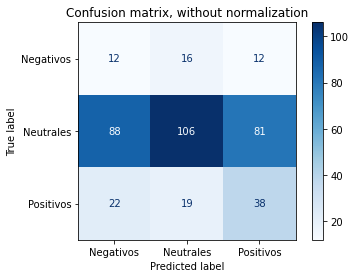

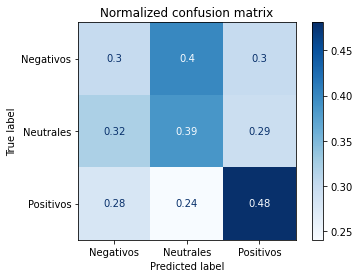

array([[ 12,  16,  12],
       [ 88, 106,  81],
       [ 22,  19,  38]])

In [156]:
X_train = df_train[features]
X_test = df_test[features]

y_train = df_train.label
y_test = df_test.label


scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

svc = svm.SVC(C=.1, kernel='linear', class_weight="balanced", gamma='auto')

svc.fit(X_train,y_train)

yhat_svc=svc.predict(X_test)

acc = metrics.accuracy_score(yhat_svc, y_test)

conf_matrix = metrics.confusion_matrix(y_test, yhat_svc)
print(conf_matrix)

print(acc)
class_names = ['Negativos', 'Neutrales', 'Positivos']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(svc, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.show()

metrics.confusion_matrix(y_test, yhat_svc)


IBM